<a href="https://colab.research.google.com/github/Hanbin-git/dacon_new_drug/blob/main/20250723.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -o "/content/drive/MyDrive/data.zip" -d "/content/data_1"

Archive:  /content/drive/MyDrive/data.zip
  inflating: /content/data_1/sample_submission.csv  
  inflating: /content/data_1/test.csv  
  inflating: /content/data_1/train.csv  


In [ ]:
# ==============================================================================
# ✅ 초기 환경 설정 및 라이브러리 설치 (가장 먼저 실행)
# ==============================================================================

# 1. pip 캐시를 모두 비웁니다.
print("Clearing pip cache...")
!pip cache purge

# 2. numpy와 scikit-learn 관련 패키지를 강제로 제거합니다.
print("Uninstalling numpy and scikit-learn related packages...")
!pip freeze | grep -E 'numpy|scikit-learn' | xargs -n 1 pip uninstall -y

# 3. Colab 기본 라이브러리 (TensorFlow, Numba 등)와 호환되는 특정 버전의 numpy와 scikit-learn을 설치합니다.
#    numpy를 1.26.x 대로 낮춰서 시도합니다.
print("Installing compatible versions of numpy and scikit-learn (attempting numpy 1.26.x)...")
!pip install numpy==1.26.4 scikit-learn==1.6.0 --no-cache-dir --quiet

# 4. 나머지 필요한 라이브러리들을 설치합니다.
print("Installing other necessary libraries...")
!pip install rdkit-pypi catboost xgboost lightgbm optuna --no-cache-dir --quiet

# 5. 파이썬 런타임을 강제로 재시작합니다. (가장 중요!)
print("Forcing runtime restart... Please wait a few seconds for reconnection.")
import os
os.kill(os.getpid(), 9)

# ==============================================================================

Clearing pip cache...
Files removed: 0
Uninstalling numpy and scikit-learn related packages...
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Installing compatible versions of numpy and scikit-learn (attempting numpy 1.26.x)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 300.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 292.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.

In [2]:
# numpy & scikit-learn 호환성 보장 버전으로 재설치
!pip install numpy==1.26.4 scikit-learn==1.5.0 --force-reinstall --quiet --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 290.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 302.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 319.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python

In [3]:
!pip install rdkit-pypi catboost xgboost lightgbm optuna --quiet --no-cache-dir


In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
# ✅ 1. 라이브러리 불러오기
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdFMCS
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import rdMolDescriptors

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA

sns.set_style('whitegrid')


In [3]:
# 데이터 불러오기 및 Mol 변환
# Colab 환경에 train.csv가 있다고 가정
# 경로 예: /content/data_1/train.csv
df = pd.read_csv("/content/data_1/train.csv")  # 경로 조정 필요 시 변경
df["mol"] = df["Canonical_Smiles"].apply(lambda smi: Chem.MolFromSmiles(smi))
df = df[df["mol"].notnull()].reset_index(drop=True)

print(f"✅ 유효한 Mol 수: {len(df)}")


✅ 유효한 Mol 수: 1681


In [4]:
# MCS 유사도 계산 함수
def compute_mcs_similarity(mols):
    n = len(mols)
    sim = np.eye(n)
    for i in range(n - 1):
        for j in range(i + 1, n):
            res = rdFMCS.FindMCS([mols[i], mols[j]])
            na = res.numAtoms
            a1, a2 = mols[i].GetNumAtoms(), mols[j].GetNumAtoms()
            sim_val = na / (a1 + a2 - na) if (a1 + a2 - na) > 0 else 0
            sim[i, j] = sim[j, i] = sim_val
    return sim


In [5]:
# 유사도 히트맵 & PCA 시각화 함수
def plot_heatmap(sim_matrix, ids, title, threshold=None, method='single'):
    dist = 1.0 - sim_matrix
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method=method)

    sns.clustermap(
        pd.DataFrame(sim_matrix, index=ids, columns=ids),
        row_linkage=Z, col_linkage=Z,
        cmap='vlag', figsize=(10, 10)
    )
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.show()

    if threshold is not None:
        plt.figure(figsize=(12, 4))
        dendrogram(Z, no_labels=True)
        plt.axhline(y=threshold, color='red', linestyle='--')
        plt.title(f"Dendrogram (threshold={threshold})", fontsize=12)
        plt.xlabel('Distance')
        plt.ylabel('Cluster')
        plt.show()

        clusters = fcluster(Z, t=threshold, criterion='distance')
        counts = pd.Series(clusters).value_counts()
        print("Clusters (size > 5):")
        print(counts[counts > 5])

def plot_pca(sim_matrix, ids, inhibition, cmap='viridis', title='PCA on Similarity'):
    pcs = PCA(n_components=2).fit_transform(sim_matrix)
    df_pca = pd.DataFrame(pcs, index=ids, columns=['PC1', 'PC2'])
    df_pca['Inhibition'] = inhibition.values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_pca, x='PC1', y='PC2',
        hue='Inhibition', palette=cmap,
        edgecolor='none'
    )
    plt.title(title, fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Inhibition', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pytho

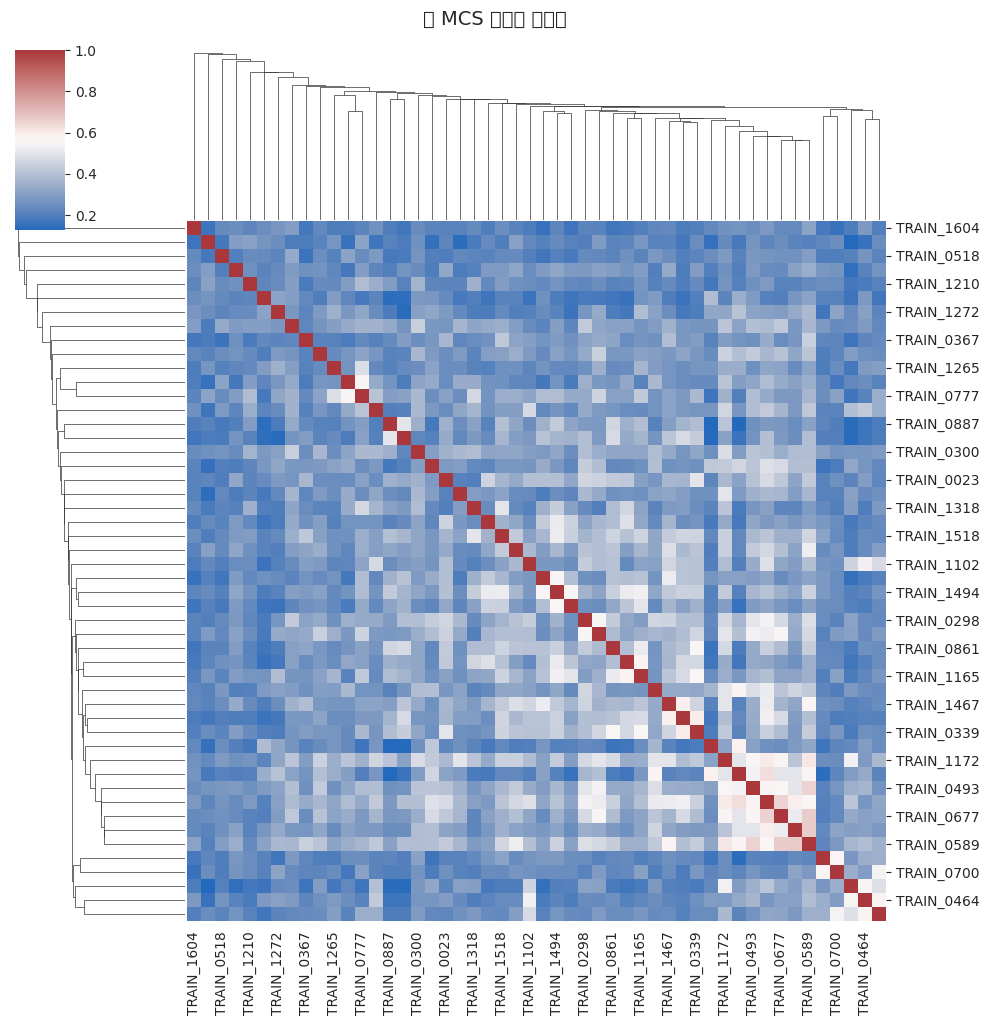

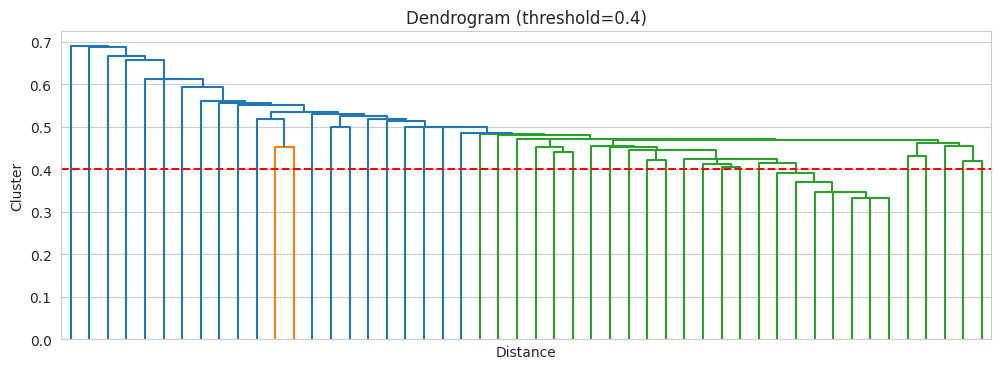

Clusters (size > 5):
14    7
Name: count, dtype: int64


/tmp/ipython-input-5-4240290519.py:44: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


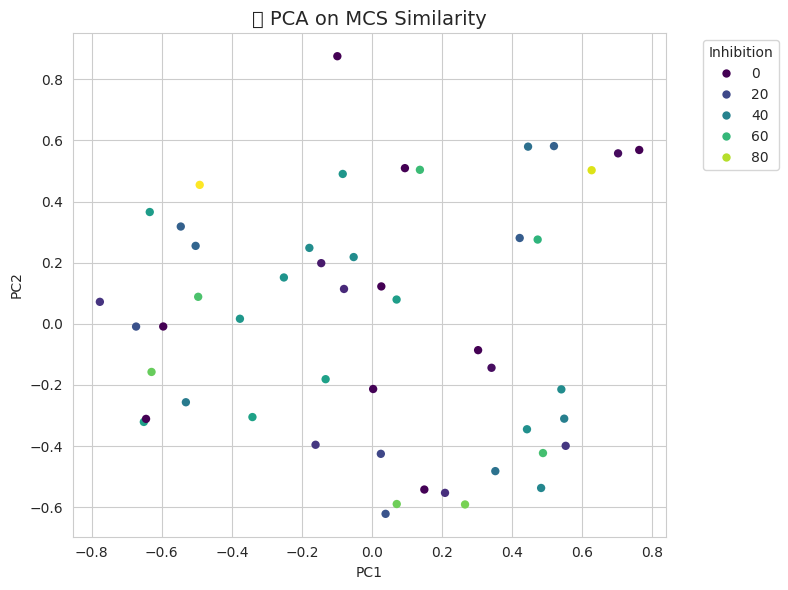

In [6]:
sample_df = df.sample(50, random_state=42).copy()  # 너무 많으면 계산 오래 걸림
mols = sample_df["mol"].tolist()
sim_matrix = compute_mcs_similarity(mols)

# 시각화
plot_heatmap(sim_matrix, sample_df["ID"].astype(str).tolist(), "📌 MCS 유사도 히트맵", threshold=0.4)
plot_pca(sim_matrix, sample_df["ID"].astype(str).tolist(), sample_df["Inhibition"], title="📌 PCA on MCS Similarity")

# 덴드로그램(Dendrogram)을 이용한 구조적 유사도 기반 계측정 클러스터링 분석
# X축 각각의 분자 샘플들 (또는 유사한 샘플끼리 묶인 그룹)
# Y축 (Distance): 샘플 또는 클러스터 간의 거리 (1 - MCS 유사도 기반)
# 세로선: 클러스터 병합
# 수평선: 클러스터 간 결합 거리 (높을수록 덜 유사)
# 빨간 점선(threshold=0.4): 해당 거리에서 클러스터를 자르는 기준선
# threshold=0.4	유사도 기준 :  0.6 이상(1 - 0.4)인 분자들을 같은 클러스터로 묶음
# 수평선 아래의 세로 묶음들 :	각 클러스터 그룹
# 우측(녹색)의 조밀한 그룹 : 서로 매우 유사한 구조를 가진 분자군
# 좌측(파란색)의 넓은 간격 : 구조적으로 이질적인 분자들, 유사성이 낮음



# PCA on MCS Similarity 시각화 해석
# PCA1, PCA2: MCS 유사도 기반 거리 행렬을 저차원(2D)으로 축소한 축
# 점 하나 = 하나의 분자
# 색상 = 저해율(Inhibition) 수준

# 비슷한 위치에 있는 점들 = 구조적으로 유사한 분자들
# 색상 분포가 일정하지 않음 : 구조만으로 완전히 설명되지 않는 저해율 다양성이 존재함]
# 고저해율 분포 확인 : 무작위적으로 색상이 분포, MCS 구조만으로 저해율을 예측하는 데는 한계가 있음

In [8]:
# 클러스터 수 확인
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

# MCS 유사도 행렬이 sim_matrix 라고 가정
dist = 1.0 - sim_matrix
condensed = squareform(dist, checks=False)
Z = linkage(condensed, method='single')  # or 'average', 'complete'

threshold = 0.4
clusters = fcluster(Z, t=threshold, criterion='distance')

# 클러스터별 샘플 수
cluster_counts = pd.Series(clusters).value_counts().sort_values(ascending=False)
print("✅ 클러스터별 샘플 수:")
print(cluster_counts[cluster_counts > 2])  # 의미 있는 클러스터만 표시

# 주요 클러스터 수	1개 (Cluster 14, size=7)
# 클러스터 내 분자 수	7개
# 시사점 : 구조적으로 매우 유사한 분자 7개가 하나의 패턴을 형성하고 있음

✅ 클러스터별 샘플 수:
14    7
Name: count, dtype: int64


In [10]:
from scipy.cluster.hierarchy import fcluster

threshold = 0.4  # 본인이 설정한 값
clusters = fcluster(Z, t=threshold, criterion='distance')
sample_df["Cluster"] = clusters

# 클러스터 14의 Inhibition 평균 분석
cluster_14_df = sample_df[sample_df["Cluster"] == 14]
cluster_14_df[["ID", "Inhibition"]]

# 클러스터 14의 평균/표준편차
print("✅ Cluster 14 평균 저해율:", cluster_14_df["Inhibition"].mean())
print("✅ Cluster 14 표준편차:", cluster_14_df["Inhibition"].std())

# 저해율이 일정하지 않고, 편차가 큰 편
# 해당 구조군이 예측에는 도움이 되지만 결정적인 구조 신호는 아닐 수 있음

✅ Cluster 14 평균 저해율: 30.01285714285714
✅ Cluster 14 표준편차: 33.20048931079466


/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-11-707166184.py:26: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout

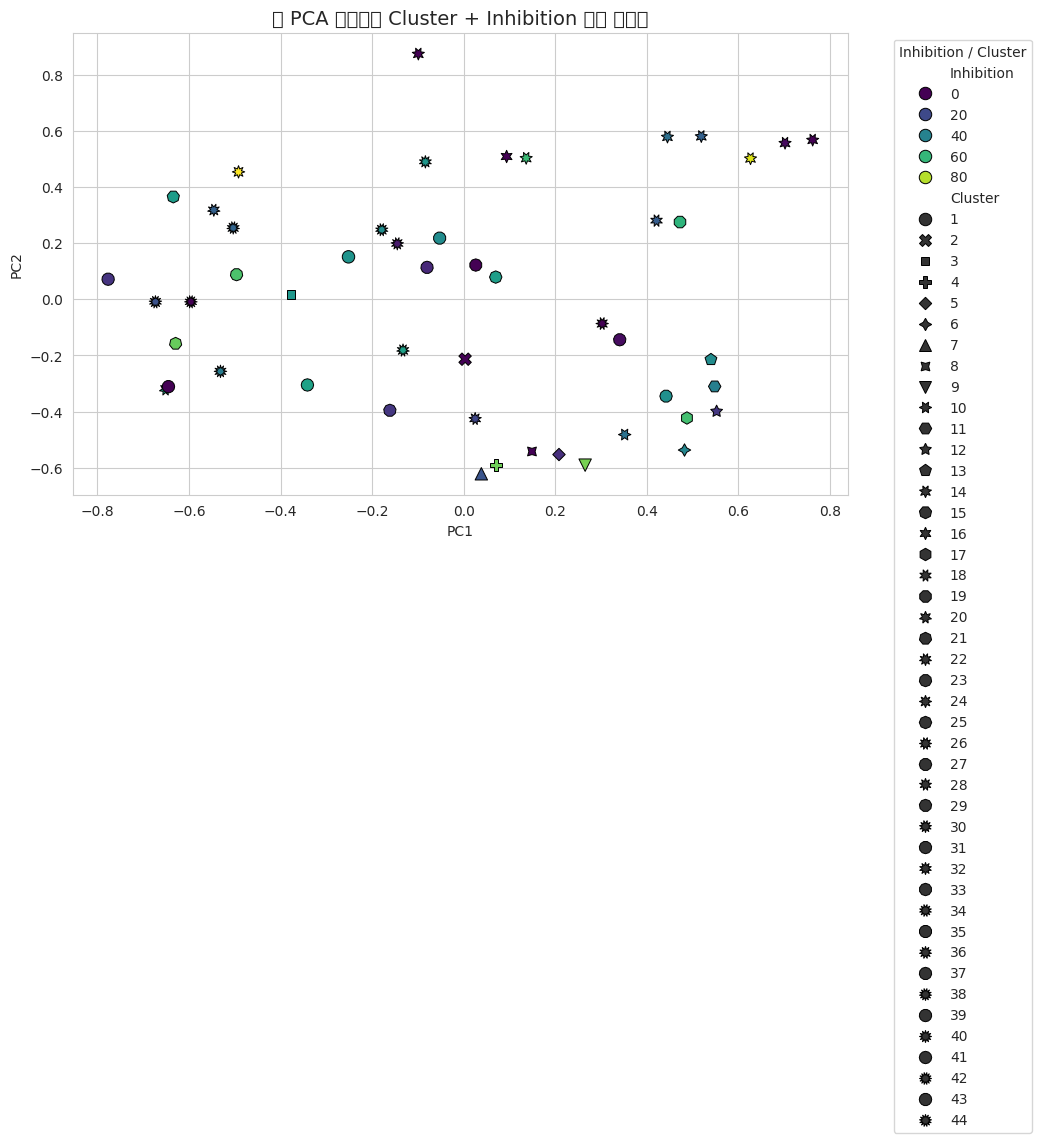

In [11]:
# 전체 코드 (PCA + 클러스터 색상 혼합 시각화)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ PCA 수행 (MCS 유사도 행렬 → 2D)
pcs = PCA(n_components=2).fit_transform(sim_matrix)
sample_df["PC1"] = pcs[:, 0]
sample_df["PC2"] = pcs[:, 1]

# ✅ 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample_df,
    x='PC1', y='PC2',
    hue='Inhibition',
    style='Cluster',  # 클러스터별 마커 스타일
    palette='viridis',
    s=80,
    edgecolor='black'
)

plt.title("📌 PCA 공간에서 Cluster + Inhibition 혼합 시각화", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), title='Inhibition / Cluster')
plt.tight_layout()
plt.show()


In [ ]:
# 같은 마커(모양)끼리 PCA 공간에서 가깝게 모여 있다면, 구조적으로 유사한 분자군이 시각적으로도 확인됨
# 다수의 클러스터들이 잘 분리된 영역에 퍼져 있는 것도 보임 → MCS 기반 클러스터링이 의미 있음
# 일부 클러스터는 **비슷한 색상(저해율)**을 보이기도 함
# 예: 오른쪽 상단의 어떤 클러스터는 보라색 중심 (저 Inhibition)
# 그러나 많은 클러스터에서 Inhibition 값의 색상이 섞여 있음
# → 구조가 유사하더라도 저해율이 일관되진 않음
# → 추가적 물리화학적 피처, 양자화학적 특성 등이 필요

# 노란색 (고 저해율, ~80%) 점들은 위치가 소수에 국한됨 → 희귀한 고효능 구조일 수 있음
# 특정 클러스터에서만 고 저해율이 집중된다면 → 매우 중요한 구조 신호 가능


In [12]:
sample_df.groupby("Cluster")["Inhibition"].agg(["count", "mean", "std"]).sort_values("mean")


,count,mean,std
Cluster,,,
33,1,0.000000,NaN
42,1,0.000000,NaN
16,1,0.000000,NaN
43,1,0.000000,NaN
26,1,0.000000,NaN
2,1,0.500000,NaN
8,1,0.500000,NaN
31,1,2.990000,NaN
30,1,6.070000,NaN


In [17]:
# SMILES → RDKit Mol 객체 변환 및 전처리 과정
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.cluster import AgglomerativeClustering

def get_morgan_fp(mol, radius=2, nBits=512):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

fps = [get_morgan_fp(m) for m in df["mol"]]
fps_arr = np.array([np.array(fp) for fp in fps])  # for PCA 등

# 유사도 거리 행렬 계산
n = len(fps)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = TanimotoSimilarity(fps[i], fps[j])
        dist_matrix[i, j] = dist_matrix[j, i] = 1 - sim

# 클러스터링 수행
agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
df["Cluster"] = agg.fit_predict(dist_matrix)


In [29]:
# ✅ 0. Import
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")

# ✅ 1. 데이터 로드 및 Mol 생성
train = pd.read_csv("/content/data_1/train.csv")
test = pd.read_csv("/content/data_1/test.csv")
sub = pd.read_csv("/content/data_1/sample_submission.csv")

train["mol"] = train["Canonical_Smiles"].map(Chem.MolFromSmiles)
test["mol"] = test["Canonical_Smiles"].map(Chem.MolFromSmiles)

train = train.dropna(subset=["mol"]).reset_index(drop=True)
test = test.dropna(subset=["mol"]).reset_index(drop=True)

# ✅ 2. 물리화학 피처 추출
physchem_cols = ['MolWt','LogP','HDonors','HAcceptors','TPSA','RotBonds','Rings','CSP3','HeavyAtoms','MR']
def extract_physchem_features(mol):
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.MolMR(mol)
    ]
train_phys = pd.DataFrame([extract_physchem_features(m) for m in train["mol"]], columns=physchem_cols)
test_phys = pd.DataFrame([extract_physchem_features(m) for m in test["mol"]], columns=physchem_cols)

# ✅ 3. Morgan Fingerprint
def get_morgan_fp(mol, radius=2, nBits=512):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
train_fp = [get_morgan_fp(m) for m in train["mol"]]

# ✅ 4. 유사도 행렬 및 군집
n = len(train_fp)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = TanimotoSimilarity(train_fp[i], train_fp[j])
        dist = 1 - sim
        sim_matrix[i, j] = sim_matrix[j, i] = dist

agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
train["Cluster"] = agg.fit_predict(sim_matrix)

# ✅ 5. 클러스터 OHE + 피처 결합
ohe = OneHotEncoder(sparse_output=False)
cluster_ohe = ohe.fit_transform(train[["Cluster"]])
cluster_ohe_test = np.zeros((test.shape[0], cluster_ohe.shape[1]))  # 테스트셋에는 클러스터 없음

X_train = pd.concat([train_phys, pd.DataFrame(cluster_ohe)], axis=1)
X_test = pd.concat([test_phys, pd.DataFrame(cluster_ohe_test)], axis=1)
y_train = train["Inhibition"]

# ✅ 6. 컬럼명 통일 및 스케일링
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ 7. 앙상블 모델 학습 및 예측
models = [
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("gb", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
    ("ridge", Ridge(alpha=1.0))
]

preds = np.zeros((X_test.shape[0], len(models)))
for i, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    preds[:, i] = model.predict(X_test)

# ✅ 8. 평균 앙상블
final_preds = preds.mean(axis=1)

# ✅ 9. 제출
sub["Inhibition"] = final_preds
sub.to_csv("submission_clustered_ensemble.csv", index=False)
print("✅ 제출 파일 저장 완료: submission_clustered_ensemble.csv")


✅ 제출 파일 저장 완료: submission_clustered_ensemble.csv


In [31]:
# ✅ 0. Import
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs  # ← 이거 꼭 필요함
from rdkit.Chem import AllChem, Descriptors
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

# ✅ 1. 데이터 로드
train = pd.read_csv("/content/data_1/train.csv")
test = pd.read_csv("/content/data_1/test.csv")
sub = pd.read_csv("/content/data_1/sample_submission.csv")

train["mol"] = train["Canonical_Smiles"].map(Chem.MolFromSmiles)
test["mol"] = test["Canonical_Smiles"].map(Chem.MolFromSmiles)

train = train.dropna(subset=["mol"]).reset_index(drop=True)
test = test.dropna(subset=["mol"]).reset_index(drop=True)

# ✅ 2. 물리화학 피처
physchem_cols = ['MolWt','LogP','HDonors','HAcceptors','TPSA','RotBonds','Rings','CSP3','HeavyAtoms','MR']
def extract_physchem_features(mol):
    return [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.RingCount(mol),
        Descriptors.FractionCSP3(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.MolMR(mol)
    ]
train_phys = pd.DataFrame([extract_physchem_features(m) for m in train["mol"]], columns=physchem_cols)
test_phys = pd.DataFrame([extract_physchem_features(m) for m in test["mol"]], columns=physchem_cols)

# ✅ 3. Morgan Fingerprint
def get_morgan_fp(mol, radius=2, nBits=256):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)  # ✅ 수정된 부분
    return arr
train_fp = np.array([get_morgan_fp(m) for m in train["mol"]])
test_fp = np.array([get_morgan_fp(m) for m in test["mol"]])

# ✅ 4. 유사도 행렬 + 클러스터링
n = len(train_fp)
sim_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        sim = TanimotoSimilarity(AllChem.GetMorganFingerprint(train["mol"][i], 2),
                                 AllChem.GetMorganFingerprint(train["mol"][j], 2))
        dist = 1 - sim
        sim_matrix[i, j] = sim_matrix[j, i] = dist

agg = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='average')
train["Cluster"] = agg.fit_predict(sim_matrix)

# ✅ 5. 클러스터 OHE
ohe = OneHotEncoder(sparse_output=False)
cluster_ohe = ohe.fit_transform(train[["Cluster"]])
cluster_ohe_test = np.zeros((test.shape[0], cluster_ohe.shape[1]))  # 테스트셋은 클러스터 없음

# ✅ 6. 피처 결합
X_train = np.concatenate([train_phys.values, train_fp, cluster_ohe], axis=1)
X_test = np.concatenate([test_phys.values, test_fp, cluster_ohe_test], axis=1)
y_train = train["Inhibition"]

# ✅ 7. 정규화 (QuantileTransformer → 극단값 반영에 유리)
scaler = QuantileTransformer(output_distribution='normal')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ 8. 앙상블 모델
models = [
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42)),
    ("gb", GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)),
    ("ridge", Ridge(alpha=1.0))
]

preds = np.zeros((X_test.shape[0], len(models)))

for i, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    preds[:, i] = model.predict(X_test)

# ✅ 9. 평균 앙상블
final_preds = preds.mean(axis=1)

# ✅ 10. 제출
sub["Inhibition"] = final_preds
sub.to_csv("submission_clustered_ensemble_v2.csv", index=False)
print("✅ 제출 파일 저장 완료: submission_clustered_ensemble_v2.csv")


✅ 제출 파일 저장 완료: submission_clustered_ensemble_v2.csv
